## Introduction

Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from fastai import *
from fastai.text.all import *
from datetime import datetime

set_seed(42)

Set paths and create dataframes for the sentiment and US politicians datasets

In [2]:
us_path = Path('../input/us-politicians-twitter-dataset')
sent_path = Path('../input/sentiment140')
tweets_path = Path('../input/ustweetssent')


us_df = pd.read_csv(us_path/'dataset.csv', encoding='latin-1')
sent_df = pd.read_csv(sent_path/'training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None, names=['sentiment', 'ID', 'Date', 'Flag', 'User', 'text'])
tweets_df = pd.read_csv(tweets_path/'us_tweets_sent_v2.csv', encoding='latin-1', parse_dates=['time'])

Display the first 5 rows of each dataset.

In [69]:
us_df.head()

,Name,Twitter_username,Account_start_time,Account_ID,Sex,Birthplace,Birthday,Age,Instagram_username,Political_party
0,A. Donald McEachin,RepMcEachin,2017-01-03T00:00:00Z,816181091673448448,male,Germany,1961-10-10T00:00:00Z,59.0,repmceachin,Democratic Party
1,Aaron Michlewitz,RepMichlewitz,2010-06-27T00:00:00Z,160246973,male,United States of America,1978-01-01T00:00:00Z,42.0,NaN,Democratic Party
2,Aaron Peskin,AaronPeskin,2010-11-13T00:00:00Z,215369273,male,United States of America,1964-06-17T00:00:00Z,56.0,apeskin52,Democratic Party
3,Aaron PeÃ±a,AaronPena,2007-10-31T00:00:00Z,9843332,male,United States of America,1959-06-08T00:00:00Z,61.0,NaN,Republican Party
4,Aaron Schock,aaronschock,2009-03-12T00:00:00Z,23951197,male,United States of America,1981-05-28T00:00:00Z,39.0,aaronschock,Republican Party


In [ ]:
sent_df.head()

In [ ]:
sent_df.shape

In [ ]:
sent_df['sentiment'].value_counts()

The sentiment140 dataset (sent_df) has 1.6 million rows of data. When training with this set, the memory limit on Kaggle was reached, so a random sample of 800 000 tweets has been collected. Unwanted columns have been dropped and positive sentiment has been changed from a value of 4 to 1, and negative from 0 to -1.

In [ ]:
sent_df_sample = sent_df.sample(n=800000)
sent_df_sample = sent_df_sample.drop(axis=0, columns=['ID', 'Date', 'Flag', 'User'])
sent_df_sample.loc[sent_df_sample.sentiment == 4, 'sentiment'] = 1
sent_df_sample.loc[sent_df_sample.sentiment == 0, 'sentiment'] = -1

In [ ]:
sent_df_sample['sentiment'].value_counts()

## Language Model

Train a Wikitext 103 language model on the sentiment tweets dataset. The language model will predict the next word of a sentence. The language model will then be trained as a sentiment classifier. This methodology is known as the ULMFit approach, and improves accuracy.

In [ ]:
dls_lm = TextDataLoaders.from_df(sent_df_sample, text_col='text', is_lm=True)

In [ ]:
dls_lm.show_batch(max_n=2)

Create model

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Fit for one epoch whilst frozen.

In [ ]:
learn.fit_one_cycle(1, 2e-2)

Unfreeze model and train for 4 epochs, which was found to be the optimal number from previous tests. Save weights.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, 2e-3)

In [ ]:
learn.save_encoder('finetuned_800k')

## Classification Model

In [ ]:
dls_class = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(sent_df_sample, bs=64)

dls_class.show_batch(max_n=2)

Copy weights to path where FastAI expects them '/models'

In [ ]:
if not os.path.exists('models'):
        os.makedirs('models')
!cp '../input/tweets-languagemodel/finetuned_comb4.pth' 'models/finetuned_comb4.pth'
!cp '../input/tweets-languagemodel/classifier.pth' 'models/classifier.pth'

Create model and load encoder weights from language model.

In [ ]:
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [ ]:
learn.load_encoder('finetuned_800k')

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

Final accuracy of 83.6% achieved. Ideally should be higher, especially when compared to models trained on IMDb datasets, but I have not been able to find a dataset of tweets with three labels of positive, negative and neutral, with an adequate size for training.

In [ ]:
learn.save('classifier_800k')

In [ ]:
learn.load('classifier')

## Collecting Tweets from US Politicians

In [ ]:
!pip install tweepy
import tweepy

In [ ]:
consumer_key = 'b5V0twlRbIFQTsf3ccLxdJTiT'
consumer_secret = 'TMro0NvOQh5jLCx6lP80Pl3qu08Iuyk2sGMV0HczDeW1LLqH8p'
access_key = '562242130-K6ka3D23C90CPAY48xMr1yGieJYakfnTAYtFuz1a'
access_secret = 'qh14ZTpwoRJ16OHwkDdidPI4K5KHGse4cAZxovHVR3ims'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAACkuLQEAAAAAswe%2Bwca72vNoYfQap0WCrYN7yHE%3DAbhtbxHkwcFiyV8m2wlSbinjZbWONsECVmg1qS22bpMtNaekPn'

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [ ]:
us_tweets_df = pd.DataFrame(columns=['Twitter_username', 'text', 'time'])
for index, row in us_df.iterrows():
    jsons = []
    username = row['Twitter_username']
    try:
        new_jsons = api.user_timeline(screen_name=username, count=40, tweet_mode="extended")
    except tweepy.TweepError:
        print("Failed to run the command on that user, Skipping...")
    jsons.extend(new_jsons)
    tweets = [status.full_text for status in jsons]
    times = [status.created_at for status in jsons]
    for i in range(len(tweets)):
        us_tweets_df = us_tweets_df.append({'Twitter_username': username, 'text': tweets[i], 'time': times[i]}, ignore_index=True)
us_tweets_df.head()

In [ ]:
us_tweets_df.to_csv('us_tweets', encoding='utf-8', index=False)

## Analysing tweets

Applying inference to the newly collected dataset, with the pre-trained sentiment classifier.

Testing on a batch of 100 tweets, the model took about 16 seconds to classify them all. This suggests that it would take about 15000 seconds to classify all the tweets, or more than 4 hours - let's go...

In [ ]:
us_tweets_df.head()

In [ ]:
pred_dl = dls_class.test_dl(us_tweets_df['text'])

In [ ]:
preds = learn.get_preds(dl=pred_dl)

In [ ]:
preds

Preds contains the final activations (/probabilities) for each class. The predicted class is found from the largest probability. 
0 = negative sentiment, 1 = positive sentiment.

In [ ]:
us_tweets_df['sentiment'] = preds[0].argmax(dim=-1)

In [ ]:
us_tweets_df.head()

In [ ]:
us_tweets_df['sentiment'].value_counts()

In [ ]:
us_tweets_df.to_csv('us_tweets_sent_v2.csv', encoding='utf-8', index=False)

tweets_df = us_tweets_df: the DataFrame has been loaded from a csv in a new session, hence the new name.

In [3]:
tweets_df.head(1)

,Twitter_username,text,time,sentiment
0,RepMcEachin,"It is truly heartbreaking to learn of the death of USCP Officer Brian Sicknick, who was tragically murdered while defending our Capitol from insurrectionists. I am praying for his family and colleagues, and determined to uncover &amp; fix the security failures leading to his death.",2021-01-08 13:40:37,0


In [4]:
tweets_df['date'] = tweets_df['time'].dt.date

In [5]:
tweets_df.head(1)

,Twitter_username,text,time,sentiment,date
0,RepMcEachin,"It is truly heartbreaking to learn of the death of USCP Officer Brian Sicknick, who was tragically murdered while defending our Capitol from insurrectionists. I am praying for his family and colleagues, and determined to uncover &amp; fix the security failures leading to his death.",2021-01-08 13:40:37,0,2021-01-08


In [6]:
print(tweets_df.date.min())
print(tweets_df.date.max())

2009-01-28
2021-01-09


In [7]:
tweets_df['date'].iloc[0]

datetime.date(2021, 1, 8)

In [8]:
compare_date = datetime.date(datetime(2020, 12, 1))
compare_date

datetime.date(2020, 12, 1)

In [9]:
tweets_df_21 = tweets_df.loc[tweets_df['date'] >= compare_date]

In [18]:
dates = tweets_df_21['date']
dates = sorted(dates)
dates = sorted(list(set(dates)))
dates

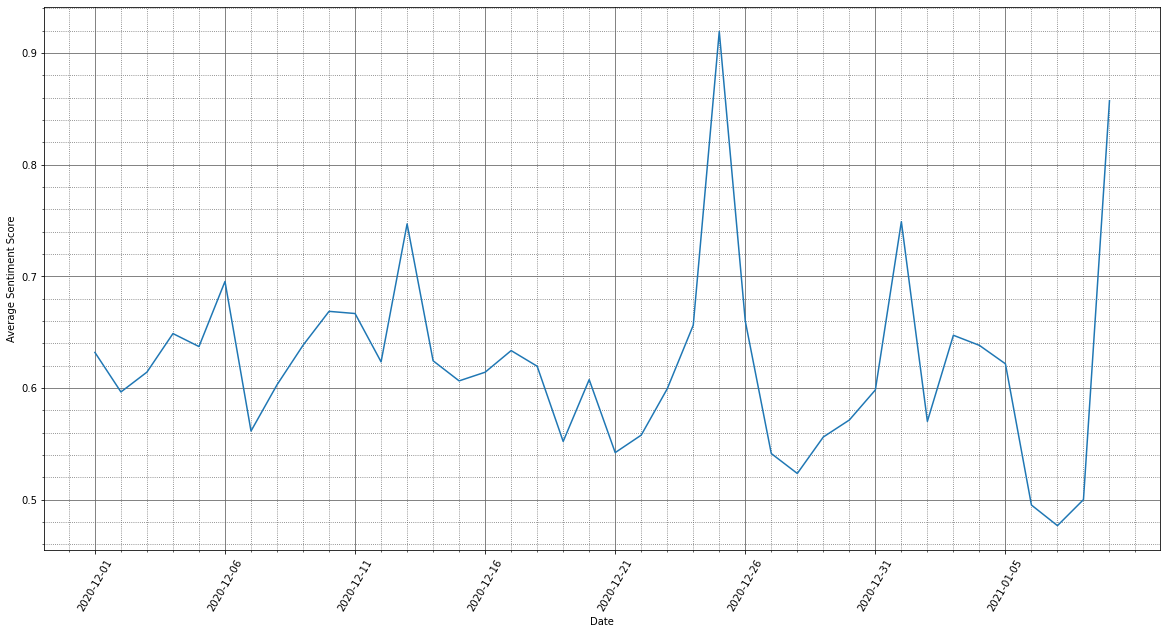

In [68]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(tweets_df.groupby(tweets_df_21['date'])["sentiment"].mean())
#tweets_df.groupby(tweets_df_21['date'])["sentiment"].mean().plot(figsize=(20,10))
plt.xticks(dates[::5], rotation='60')
plt.minorticks_on()
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.grid(b=True, which='minor', color='#666666', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()

In [70]:
Both_DFs = pd.merge(tweets_df.set_index('Twitter_username', drop=True), us_df.set_index('Twitter_username', drop=True), left_index=True, right_index=True).dropna().reset_index()

In [76]:
Both_DFs.head()

,Twitter_username,text,time,sentiment,date,Name,Account_start_time,Account_ID,Sex,Birthplace,Birthday,Age,Instagram_username,Political_party
0,AOC,Good to see this development from @Apple. @GooglePlay what are you going to do about apps being used to organize violence on your platform? https://t.co/wWVSERcRSH,2021-01-08 23:04:40,1,2021-01-08,Alexandria Ocasio-Cortez,2018-12-29T00:00:00Z,1079104563280527364,female,United States of America,1989-10-13T00:00:00Z,31.0,aoc,Democratic Party
1,AOC,Good to see this development from @Apple. @GooglePlay what are you going to do about apps being used to organize violence on your platform? https://t.co/wWVSERcRSH,2021-01-08 23:04:40,1,2021-01-08,Alexandria Ocasio-Cortez,2010-04-28T00:00:00Z,138203134,female,United States of America,1989-10-13T00:00:00Z,31.0,aoc,Democratic Party
2,AOC,What are @Apple and @GooglePlay doing about this? https://t.co/Upb2BxZOQZ,2021-01-08 22:59:26,1,2021-01-08,Alexandria Ocasio-Cortez,2018-12-29T00:00:00Z,1079104563280527364,female,United States of America,1989-10-13T00:00:00Z,31.0,aoc,Democratic Party
3,AOC,What are @Apple and @GooglePlay doing about this? https://t.co/Upb2BxZOQZ,2021-01-08 22:59:26,1,2021-01-08,Alexandria Ocasio-Cortez,2010-04-28T00:00:00Z,138203134,female,United States of America,1989-10-13T00:00:00Z,31.0,aoc,Democratic Party
4,AOC,RT @mkraju: Sen. Wyden becomes second Dem to call on Cruz and Hawley to resign. Ã¢ÂÂThere must be consequences for senators who would foment aÃ¢ÂÂ¦,2021-01-08 22:47:16,0,2021-01-08,Alexandria Ocasio-Cortez,2018-12-29T00:00:00Z,1079104563280527364,female,United States of America,1989-10-13T00:00:00Z,31.0,aoc,Democratic Party


In [77]:
Both_DFs['Political_party'].value_counts()

Democratic Party                                    40455
Republican Party                                    27605
independent politician                               1800
Minnesota DemocraticâFarmerâLabor Party          1480
California Democratic Party                          1200
Republican Party of Iowa                              800
Colorado Republican Party                             640
Libertarian Party                                     637
Liberty Union Party                                   480
North Dakota Republican Party                         320
Green Party of the United States                      200
California Republican Party                           200
Fine Gael                                             160
Conservative Party of New York State                  160
Utah Democratic Party                                 160
Peace and Freedom Party                               120
Democratic Party of Hawaii                             80
Working Famili

In [109]:
df_x = Both_DFs.loc[(Both_DFs['Political_party'] == 'Democratic Party')|  
                    (Both_DFs['Political_party'] == 'Republican Party')|
                    (Both_DFs['Political_party'] == 'Green Party of the United States')|
                   (Both_DFs['Political_party'] == 'Libertarian Party')]

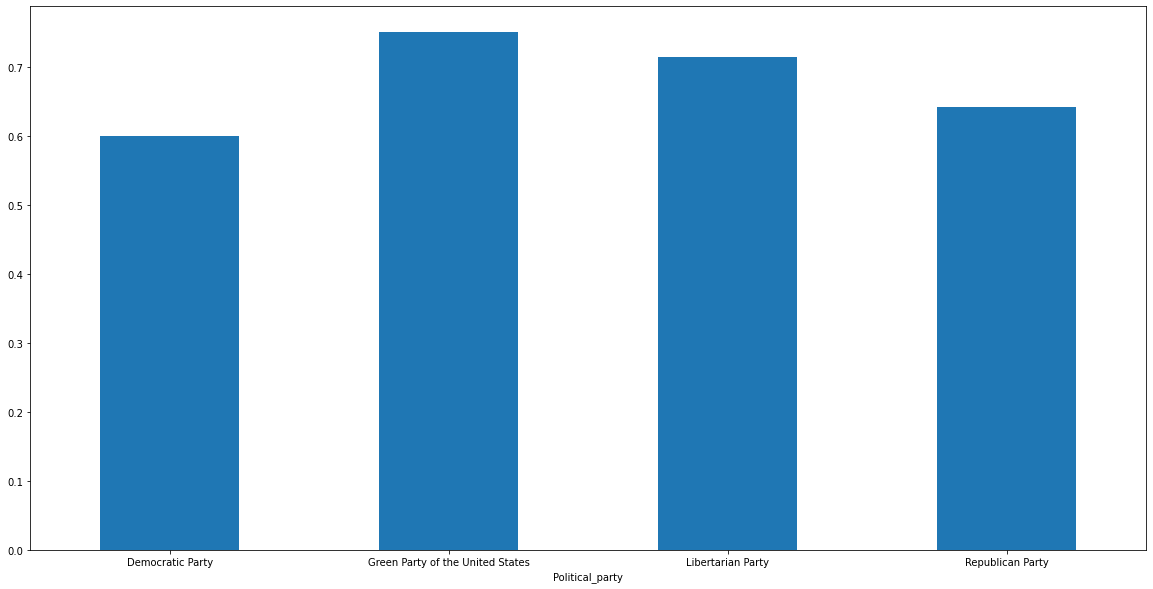

In [110]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
df_x.groupby(df_x['Political_party'])["sentiment"].mean().plot(kind='bar', rot=0, ax=ax)
plt.show()

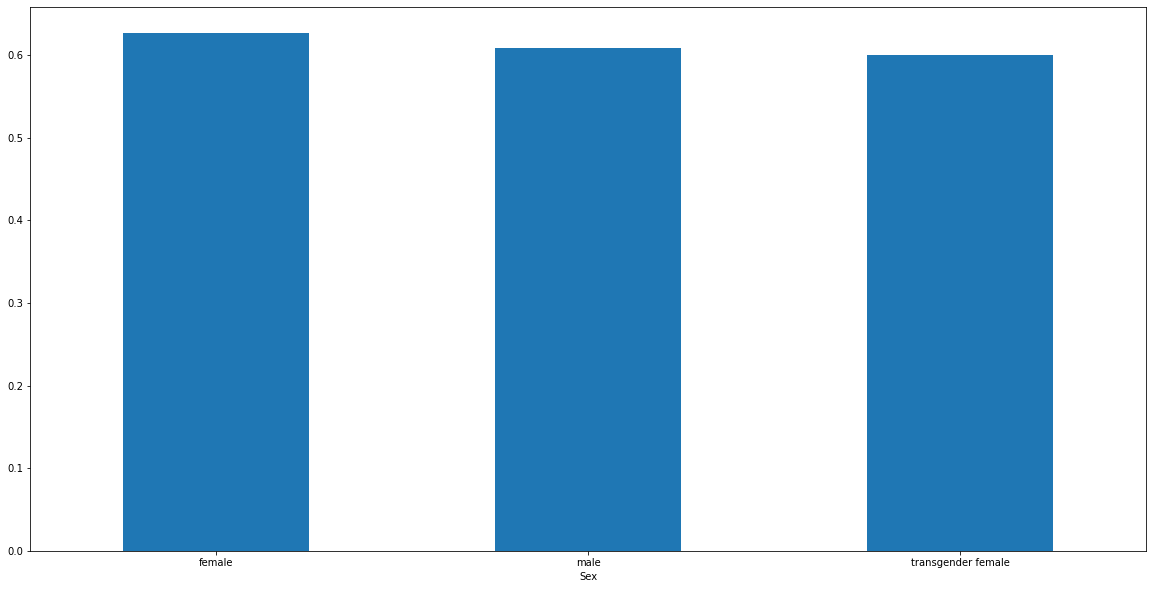

In [112]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Both_DFs.groupby(Both_DFs['Sex'])["sentiment"].mean().plot(kind='bar', rot=0, ax=ax)
plt.show()

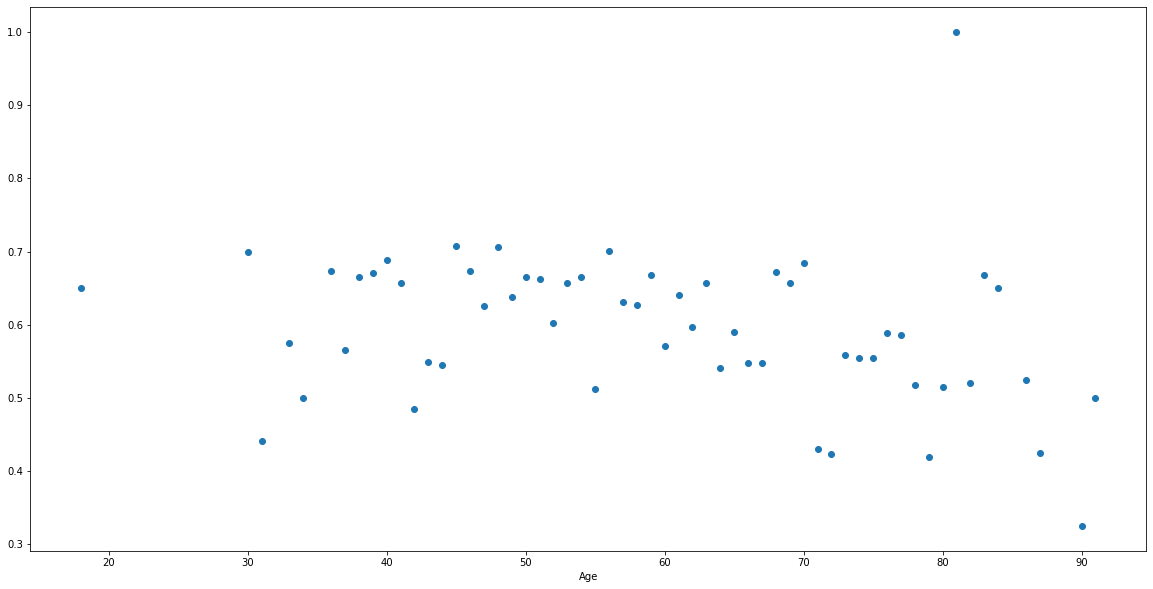

In [117]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Both_DFs.groupby(Both_DFs['Age'])["sentiment"].mean().plot(linestyle='', marker='o', rot=0, ax=ax)
plt.show()

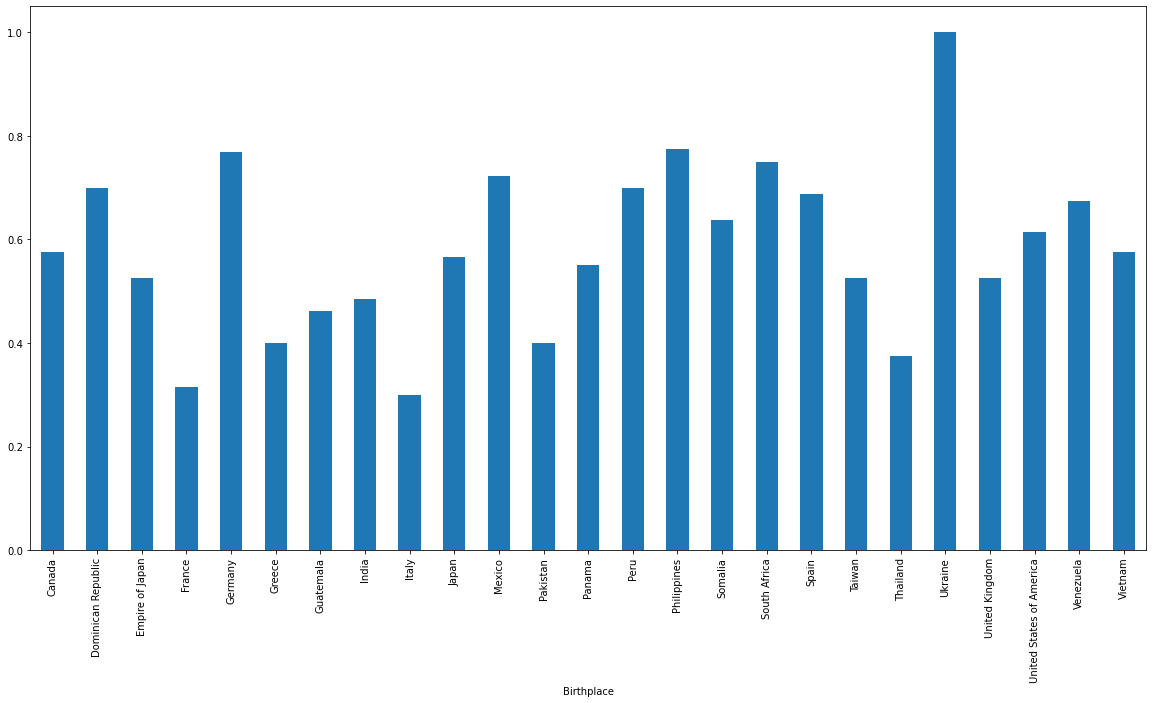

In [119]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Both_DFs.groupby(Both_DFs['Birthplace'])["sentiment"].mean().plot(kind='bar', rot=0, ax=ax)
plt.xticks(rotation='vertical')
plt.show()

In [120]:
from mpl_toolkits.basemap import Basemap

In [122]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [126]:
birthplace_sent = Both_DFs.groupby(Both_DFs['Birthplace'])["sentiment"].mean()

In [128]:
birthplace_sent

Birthplace
Canada                      0.575000
Dominican Republic          0.700000
Empire of Japan             0.525000
France                      0.315789
Germany                     0.768974
Greece                      0.400000
Guatemala                   0.462500
India                       0.484342
Italy                       0.300000
Japan                       0.566667
Mexico                      0.722222
Pakistan                    0.400000
Panama                      0.550000
Peru                        0.700000
Philippines                 0.775000
Somalia                     0.637500
South Africa                0.750000
Spain                       0.687500
Taiwan                      0.525000
Thailand                    0.375000
Ukraine                     1.000000
United Kingdom              0.525000
United States of America    0.615042
Venezuela                   0.675000
Vietnam                     0.575000
Name: sentiment, dtype: float64

In [133]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='nlp')

In [135]:
def geolocate(city=None, country=None):
    if city != None:
        try:
            loc = geolocator.geocode(str(city + ',' + country))
            return (loc.latitude, loc.longitude)
        except:
            return np.nan
    else:
        try:
            loc = geolocator.geocode(country)
            return (loc.latitude, loc.longitude)
        except:
            return np.nan

In [143]:
lat=[]
long=[]
for country in birthplace_sent.index:
    coords = geolocate(country=country)
    lat.append(coords[0])
    long.append(coords[1])

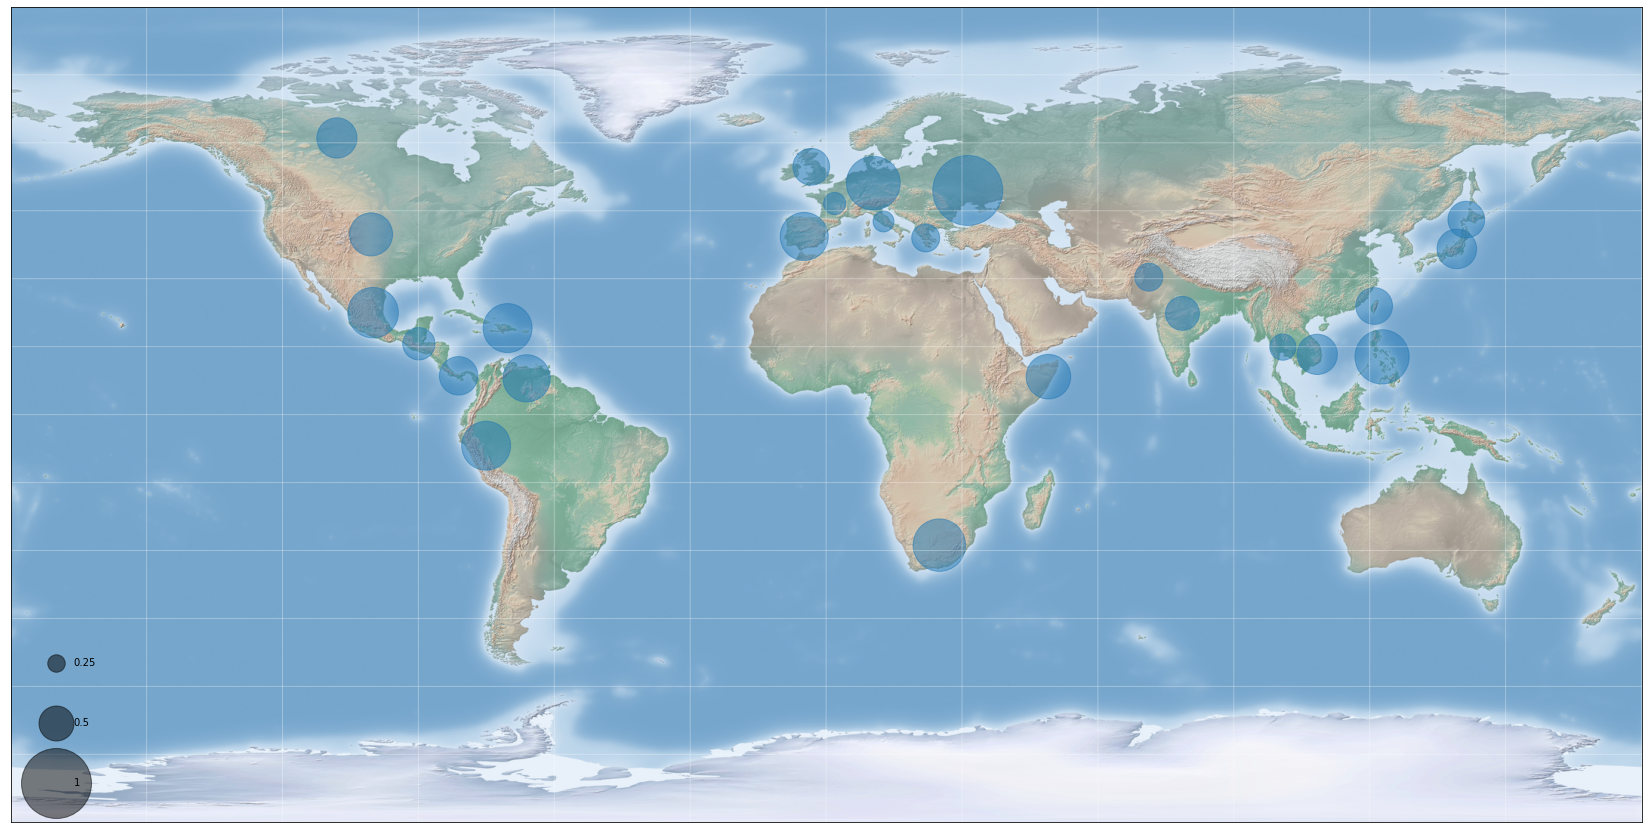

In [166]:
fig = plt.figure(figsize=(30, 15), edgecolor='w')

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)

m.scatter(long, lat, latlon=True, s=(birthplace_sent*70)**2,
          cmap='Reds', alpha=0.5)

for a in [0.25, 0.5, 1]:
    plt.scatter([], [], c='k', alpha=0.5, s=(a*70)**2,
                label=str(a))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=5, loc='lower left', borderpad = 5);

draw_map(m)